In [2]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.24.1'

In [3]:
import qiskit

qiskit.version.get_version_info()

'1.1.0'

## Setup


In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [35]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService

# Your token
token = "761537a8f6ebedc09fa5123310731dad7a03509dcd31374fea4b9935fdcdfecf373b9153eddc6e3c257e6dca66968fbc5e52e1278aeeecf47d714a05cdf59e18"

# Create the QiskitRuntimeService instance
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token=token
)

# List the available backends
print(service.backends())

backendlist = service.backends()
backend = backendlist[2]
print(backend)


[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]
<IBMBackend('ibm_osaka')>


In [3]:
pip install --user pylatexenc

Note: you may need to restart the kernel to use updated packages.


## Step 1: Map classical inputs to a quantum problem


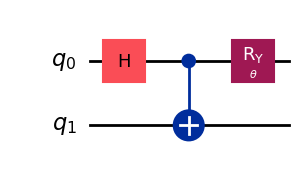

In [4]:
import pylatexenc
from qiskit.circuit import Parameter, QuantumCircuit


theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [5]:
import numpy as np

number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

In [6]:
from qiskit.quantum_info import SparsePauliOp

# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

## Step 2: Optimize problem for quantum execution


### ISA Circuit


In [7]:
pip install qiskit-aer

Note: you may need to restart the kernel to use updated packages.


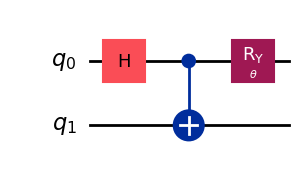

In [36]:
from qiskit_aer import Aer

# Create a backend
backend = Aer.get_backend('qasm_simulator')

# Define the target
target = backend.target

# Generate the preset pass manager
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# Run the circuit through the pass manager
chsh_isa_circuit = pm.run(chsh_circuit)

# Draw the optimized circuit
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

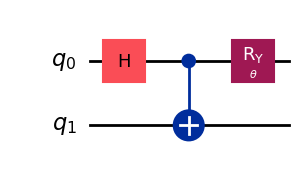

In [37]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables


In [38]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)

## Step 3: Execute using Qiskit primitives

In order to execute the entire experiment in one call to the [`Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2).


In [40]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.
from qiskit.primitives import StatevectorEstimator


estimator = StatevectorEstimator()

pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()

## Step 4: Plotting result in classical format


In [41]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

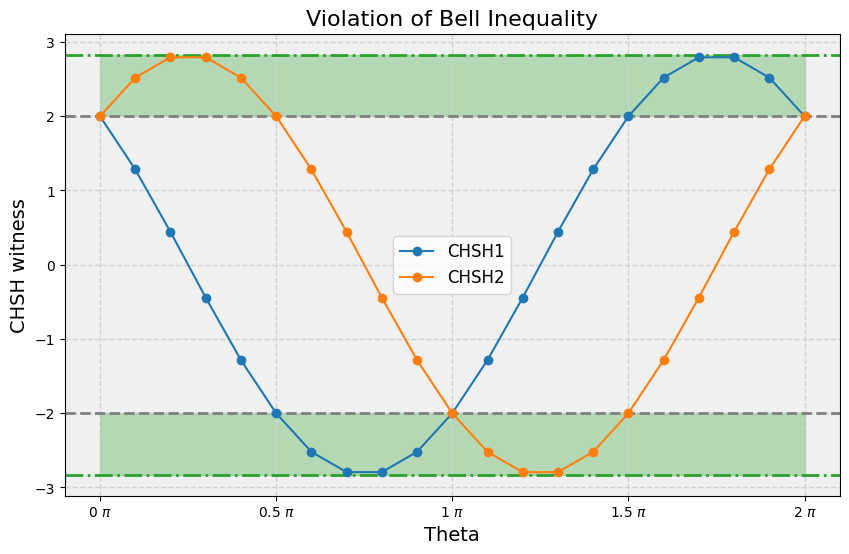

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as tck

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", color="#1f77b4", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", color="#ff7f0e", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="#7f7f7f", linestyle="--", linewidth=2)
ax.axhline(y=-2, color="#7f7f7f", linestyle="--", linewidth=2)

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="#2ca02c", linestyle="-.", linewidth=2)
ax.axhline(y=-np.sqrt(2) * 2, color="#2ca02c", linestyle="-.", linewidth=2)
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="#2ca02c", alpha=0.3)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="#2ca02c", alpha=0.3)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta", fontsize=14)
plt.ylabel("CHSH witness", fontsize=14)
plt.title("Violation of Bell Inequality", fontsize=16)
plt.legend(fontsize=12)

# change the background color
ax.set_facecolor("#f0f0f0")

# change the grid style
ax.grid(color="#d0d0d0", linestyle="--", linewidth=1)

plt.show()